### Step 1: Business Understanding
Many individuals struggle to secure loans due to limited or nontraditional credit histories, leaving them vulnerable to predatory lending or financial exclusion. Home Credit’s mission is to expand financial access using alternative data sources. By answering this question, we can help lenders make smarter, fairer decisions that reduce default rates and extend credit responsibly. If left unanswered, deserving applicants may be denied opportunities, and lenders may face unnecessary risk. This analysis translates complex data into actionable business intelligence, empowering financial institutions to enhance loan approval strategies and promote inclusive lending.

**Objective**: Predict the likelihood of loan default using demographic, financial, and behavioral data from Home Credit.

**Impact**: Improve credit access for underserved populations and reduce risk for lenders.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

import xgboost as xgb

import shap

### Step 2: Data Understanding

In [4]:
train_df = pd.read_csv('data/application_train.csv')

In [5]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
train_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [8]:
## Check null values
train_df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [9]:
## Detect Duplicates
train_df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
307506    False
307507    False
307508    False
307509    False
307510    False
Length: 307511, dtype: bool

In [10]:
# Check Target distribution
train_df['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

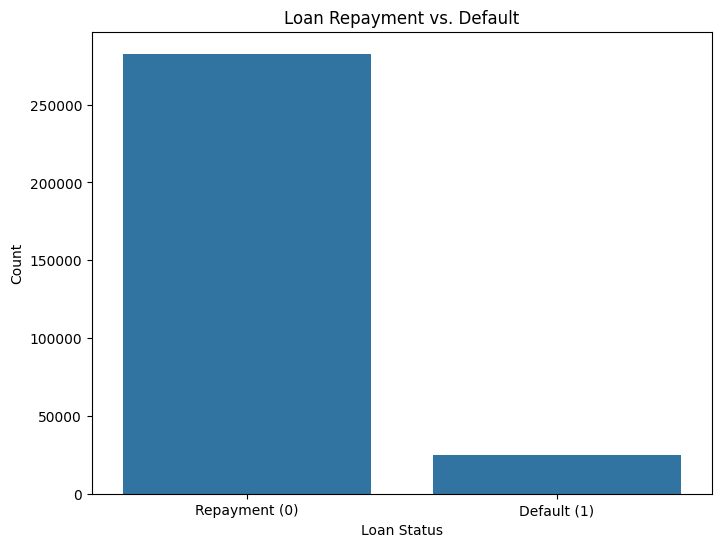

In [11]:
# Target distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='TARGET', data=train_df)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Repayment (0)', 'Default (1)'])
ax.set_title('Loan Repayment vs. Default')
ax.set_xlabel('Loan Status')
ax.set_ylabel('Count')
plt.show()

##### Target distribution shows that its a highly imbalanced dataset (~8% defaults), which is common in financial risk modeling. Most people repay their loans, but the small group who default is what we're trying to predict.

In [13]:
# Missing Values
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percent = (missing / len(train_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df.head(20)

,Missing Values,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [14]:
# Select Numerical Features
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_features

In [15]:
# Select Categorical Features
categorical_features = train_df.select_dtypes(include='object').columns.tolist()
#categorical_features

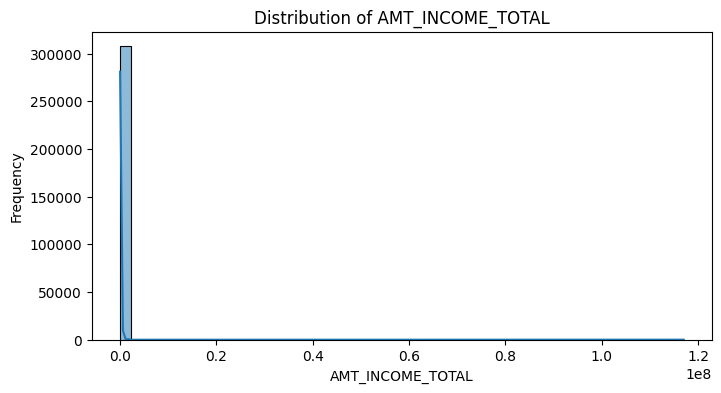

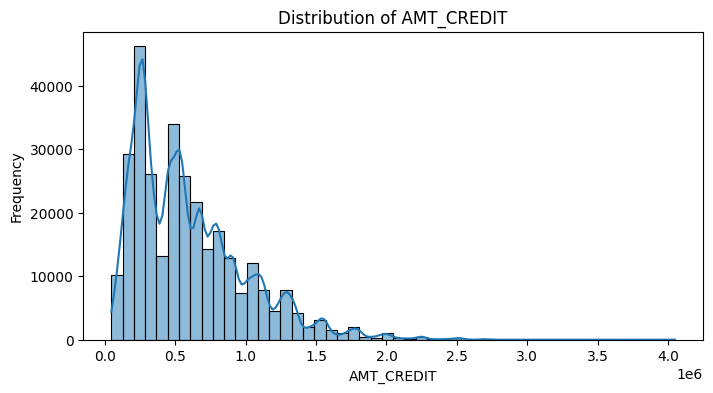

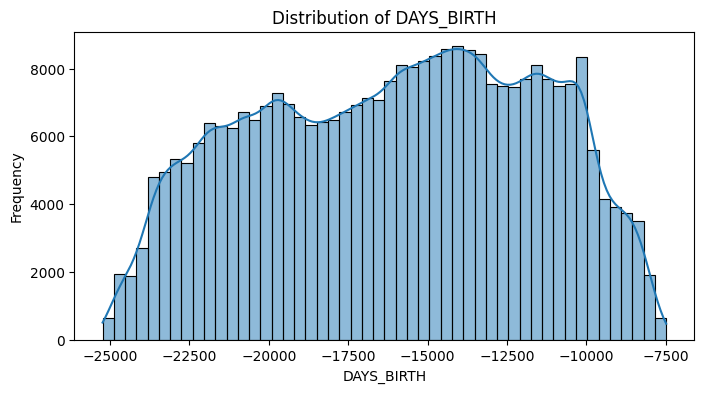

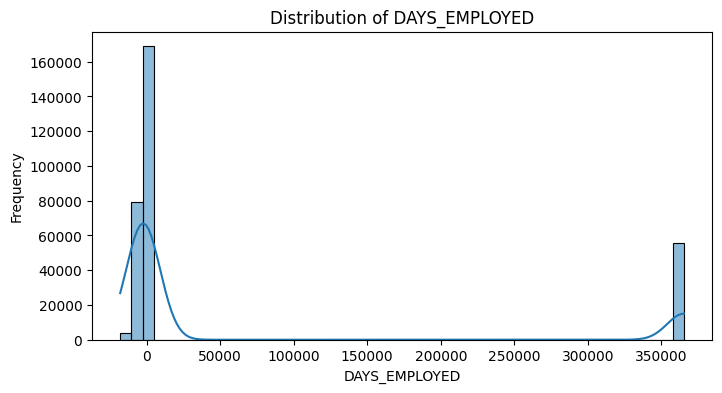

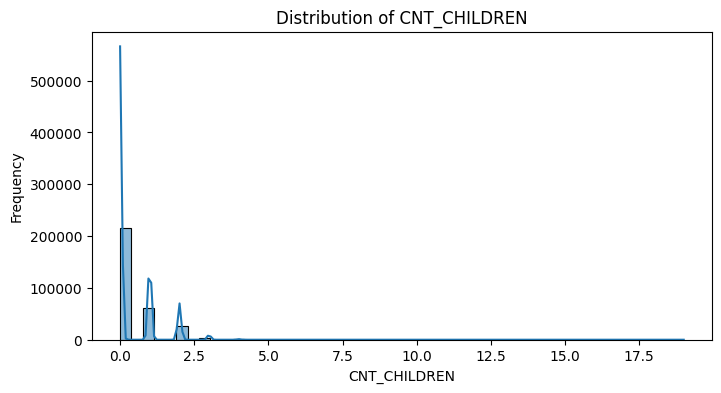

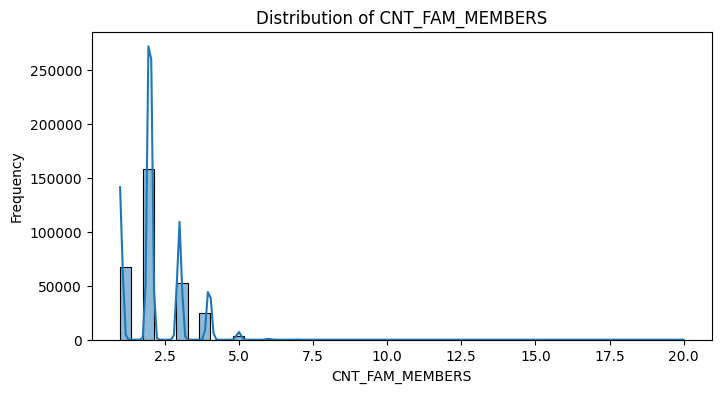

In [16]:
# Numerical Features
# AMT_INCOME_TOTAL: Applicant's total income
# AMT_CREDIT: Credit amount requested
# DAYS_BIRTH: Age in days (negative values)
# DAYS_EMPLOYED: Employment duration in days (some anomalies)
# CNT_CHILDREN: Number of children
# CNT_FAM_MEMBERS: Family size

numerical = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']

for col in numerical:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

- AMT_INCOME_TOTAL: Right-skewed due to high-income outliers. Needs log transformation
- DAYS_BIRTH: This is in days (negative values), needs to be converted to age
- DAYS_EMPLOYED: Value 365243 could mean "never employed", needs to flag it

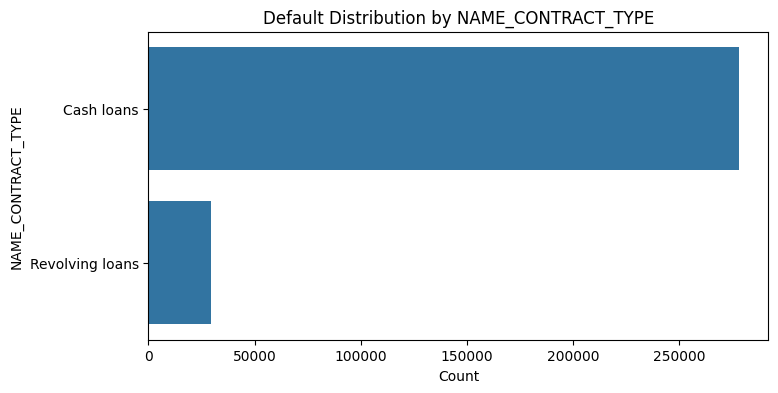

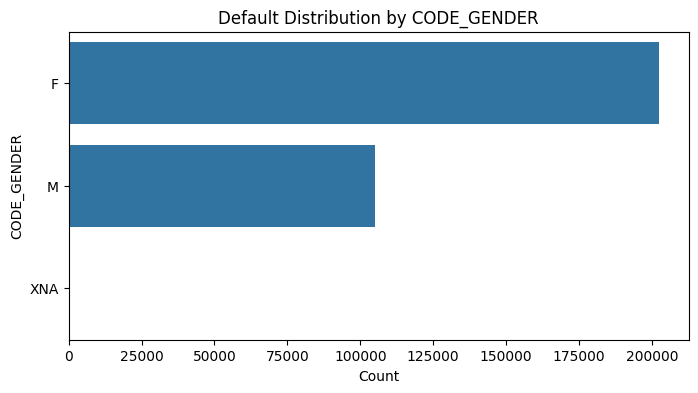

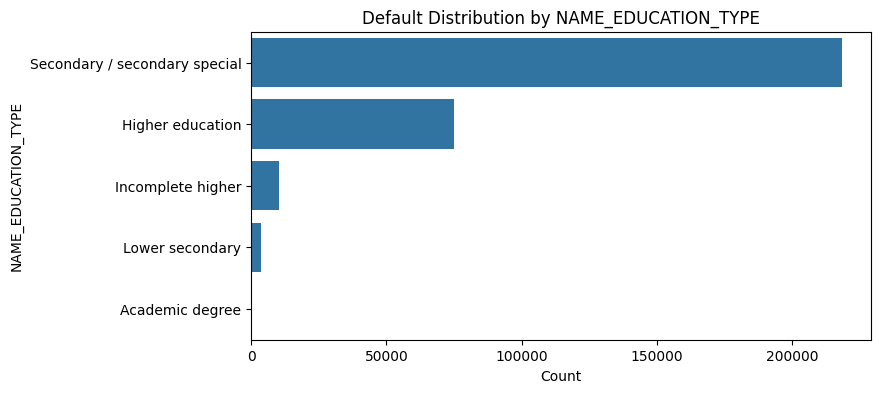

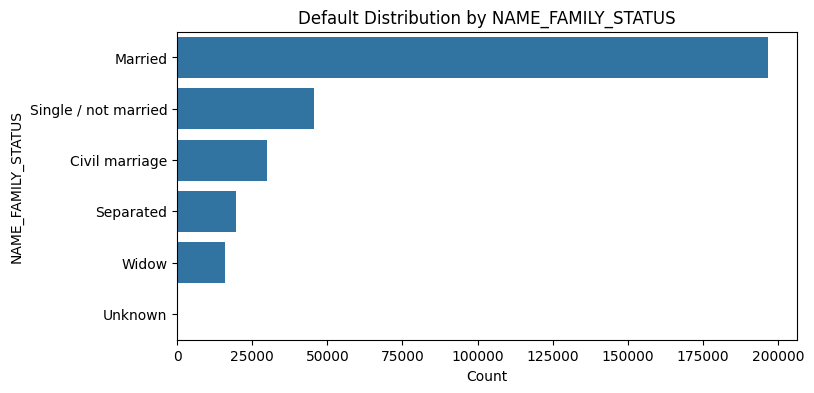

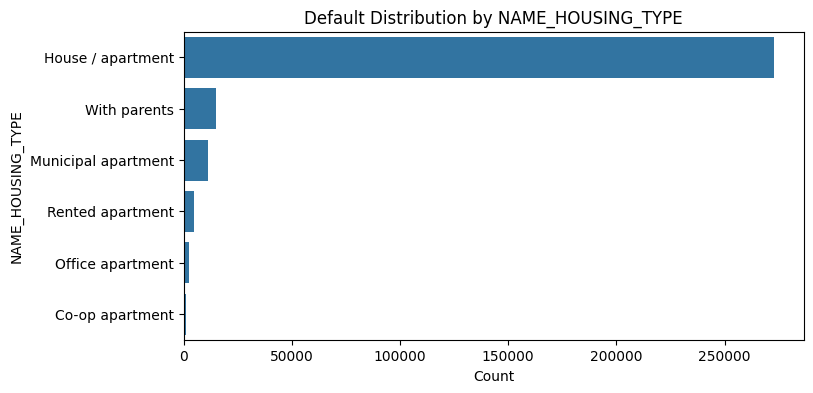

In [18]:
# Categorical Features
# NAME_CONTRACT_TYPE: Cash or revolving loan
# CODE_GENDER: Gender
# NAME_EDUCATION_TYPE: Education level
# NAME_FAMILY_STATUS: Marital status
# NAME_HOUSING_TYPE: Housing situation
# OCCUPATION_TYPE: Job category

categorical = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

for col in categorical:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, data=train_df, order=train_df[col].value_counts().index)
    plt.title(f'Default Distribution by {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

- NAME_CONTRACT_TYPE: Two types "Cash loans" vs. "Revolving loans"
- CODE_GENDER: very few 'XNA' values, we may need to drop these
- NAME_EDUCATION_TYPE: Useful for segmenting risk
- NAME_FAMILY_STATUS: Correlate with financial stability
- NAME_HOUSING_TYPE: Reflect socioeconomic status

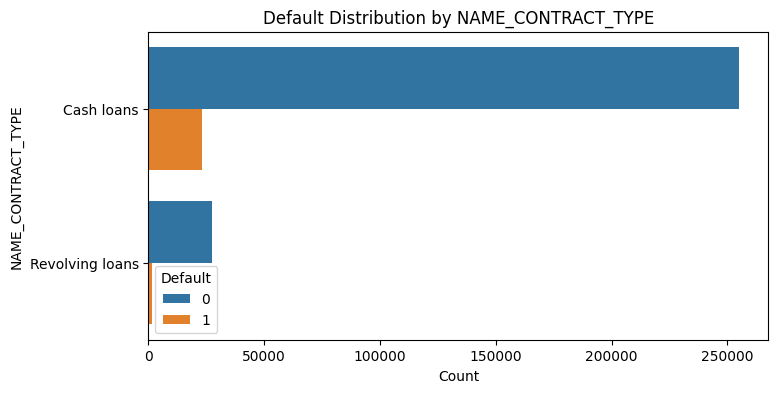

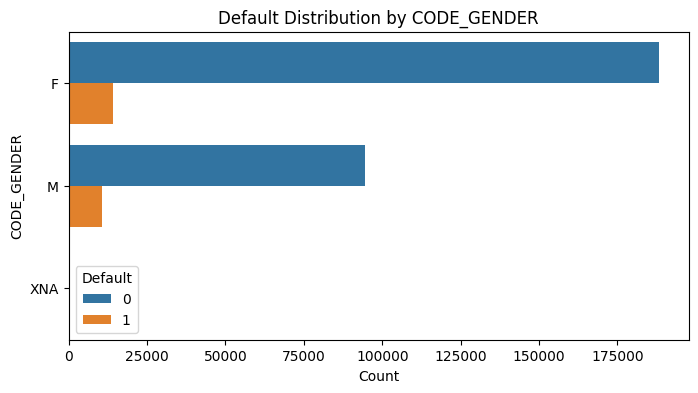

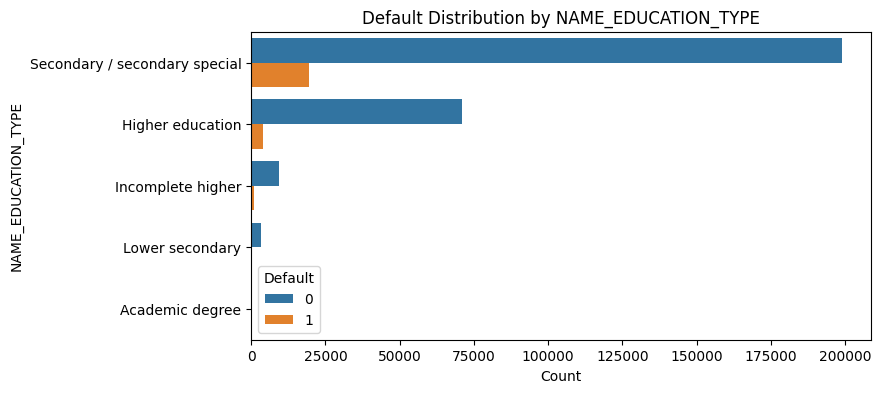

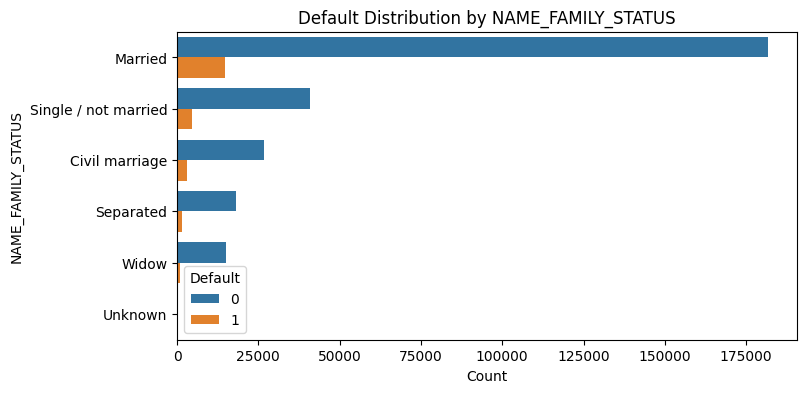

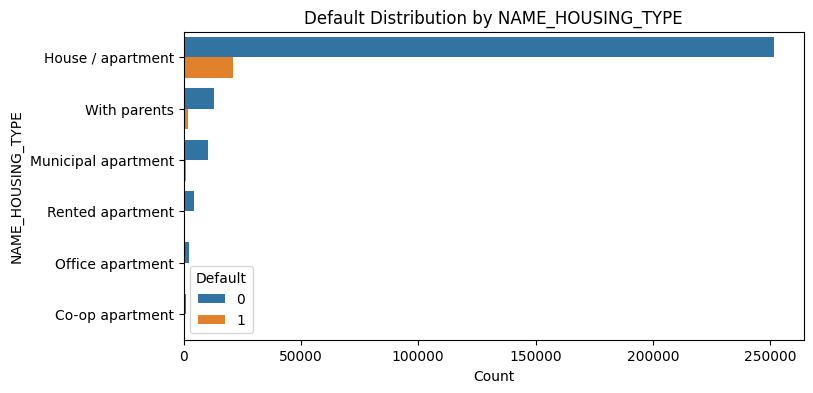

"\nsns.set_style('whitegrid')\n\nfor col in categorical:\n    plt.figure(figsize=(12, 6))\n    \n    # Create the countplot with raw counts on the x-axis\n    ax = sns.countplot(\n        y=col, \n        hue='TARGET', \n        data=train_df, \n        order=train_df[col].value_counts().index\n    )\n\n    # Calculate the total counts for each category to use in the percentage calculation\n    total_counts = train_df[col].value_counts()\n    \n    # Add annotations\n    # Iterate over the bars (patches) in the plot\n    for p in ax.patches:\n        # Get the width of the bar (which corresponds to the count)\n        width = p.get_width()\n        \n        # Get the y-position of the bar's center\n        y = p.get_y() + p.get_height() / 2\n        \n        # Find the category name corresponding to this bar\n        category_label = ax.get_yticklabels()[int(y - p.get_height()/2)].get_text()\n\n        # Get the total count for this specific category\n        total = total_counts[cat

In [20]:
# Categorical Features hue with TARGET
for col in categorical:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=col, hue='TARGET', data=train_df, order=train_df[col].value_counts().index)
    plt.title(f'Default Distribution by {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.legend(title='Default')
    plt.show()

"""
sns.set_style('whitegrid')

for col in categorical:
    plt.figure(figsize=(12, 6))
    
    # Create the countplot with raw counts on the x-axis
    ax = sns.countplot(
        y=col, 
        hue='TARGET', 
        data=train_df, 
        order=train_df[col].value_counts().index
    )

    # Calculate the total counts for each category to use in the percentage calculation
    total_counts = train_df[col].value_counts()
    
    # Add annotations
    # Iterate over the bars (patches) in the plot
    for p in ax.patches:
        # Get the width of the bar (which corresponds to the count)
        width = p.get_width()
        
        # Get the y-position of the bar's center
        y = p.get_y() + p.get_height() / 2
        
        # Find the category name corresponding to this bar
        category_label = ax.get_yticklabels()[int(y - p.get_height()/2)].get_text()

        # Get the total count for this specific category
        total = total_counts[category_label]
        
        # Calculate the percentage of the current bar relative to its category's total
        percentage = (width / total) * 100
        
        # Add the annotation text
        ax.annotate(
            f'{percentage:.1f}%', 
            (width, y),
            ha='left',
            va='center',
            fontsize=10
        )
        
    plt.title(f'Default Distribution by {col} with Percentages', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    
    plt.legend(
        title='Default Status', 
        loc='lower right', 
        labels=['Repaid (0)', 'Defaulted (1)']
    )
    
    plt.tight_layout()
    plt.show()
"""

##### Default Distribution by NAME_CONTRACT_TYPE
- It suggests that the default rate for "Revolving loans" is likely lower than for "Cash loans."

##### Default Distribution by CODE_GENDER
- It appears that the default rate for males is higher than for females. Although the absolute number of female defaulters is larger (because there are more female applicants overall), the percentage of males who default seems greater.
- The XNA category is very small and has a very low default count; it can be treated as a separate category, or drop these rows.

##### Default Distribution by NAME_EDUCATION_TYPE
- The proportion of defaulters in the "Lower secondary" appears to be relatively high, suggesting a higher risk for this group
  
##### Default Distribution by NAME_FAMILY_STATUS
- The default rates for "Separated" and "Civil marriage" appear to be a bit higher
  
##### Default Distribution by NAME_HOUSING_TYPE:
- House/apartment: This is by far the most common housing type, with the majority of applicants. Its default rate appears to be relatively low compared to other categories.
- Other categories like "With Parents", "Rented apartment", "Municipal apartment", and "Co-op apartment" have a smaller total number of applicants, but the defaulters appear to be a slightly larger proportion of the total for those bars. This suggests that applicants with these housing types may have a higher risk of defaulting, even if the total number is small.

<Axes: >

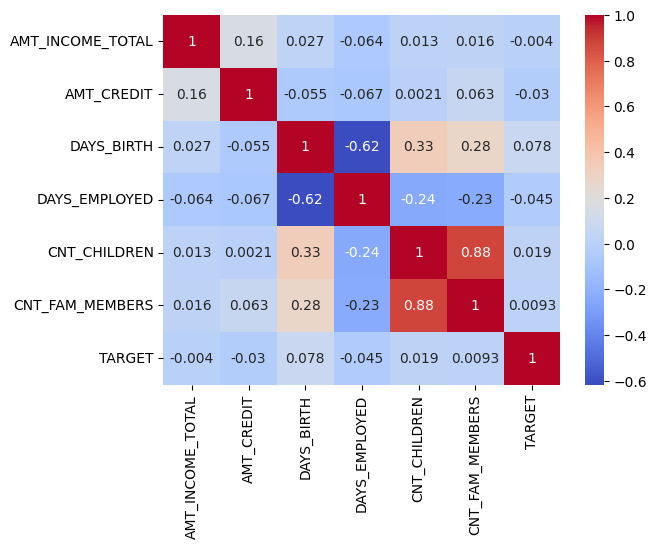

In [22]:
# Correlation Matrix for Numerical Features
corr = train_df[numerical + ['TARGET']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

##### TARGET vs. AMT_INCOME_TOTAL:
There is virtually no linear correlation between an applicant's total income and their likelihood of defaulting on the loan.

##### TARGET vs. AMT_CREDIT:
The amount of credit a person receives has a negligible linear relationship with their default status.

##### TARGET vs. DAYS_BIRTH:
There is a very weak positive correlation. Note that DAYS_BIRTH is a negative number (e.g., -10000). A positive correlation here means that as DAYS_BIRTH gets closer to 0 (i.e., the person gets older), the TARGET value (0 or 1) tends to increase. This suggests that older applicants may have a slightly higher, though very weak, propensity to default.

##### TARGET vs. DAYS_EMPLOYED:
A very weak negative correlation. DAYS_EMPLOYED is also a negative number. This means that as the absolute value of DAYS_EMPLOYED increases (i.e., a person has been employed for more days), the TARGET value tends to decrease. This suggests that applicants with longer employment histories have a very slightly lower risk of defaulting.

##### DAYS_BIRTH vs. DAYS_EMPLOYED:
This is a logical relationship. Older people (DAYS_BIRTH closer to 0) tend to have been employed for a longer period (DAYS_EMPLOYED further from 0). The negative sign is because both are represented as negative numbers of days.

##### CNT_CHILDREN vs. CNT_FAM_MEMBERS:
This is expected. The number of family members is highly correlated with the number of children. This relationship is so strong that it could potentially be a source of multicollinearity if both variables are used in a model.

In [24]:
# Grouped Statistics to calculate the default rates across different groups.
for col in categorical:
    default_rate = train_df.groupby(col)['TARGET'].mean().sort_values(ascending=False)
    print(f'\nDefault Rate by {col}:\n{default_rate}')


Default Rate by NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
Name: TARGET, dtype: float64

Default Rate by CODE_GENDER:
CODE_GENDER
M      0.101419
F      0.069993
XNA    0.000000
Name: TARGET, dtype: float64

Default Rate by NAME_EDUCATION_TYPE:
NAME_EDUCATION_TYPE
Lower secondary                  0.109277
Secondary / secondary special    0.089399
Incomplete higher                0.084850
Higher education                 0.053551
Academic degree                  0.018293
Name: TARGET, dtype: float64

Default Rate by NAME_FAMILY_STATUS:
NAME_FAMILY_STATUS
Civil marriage          0.099446
Single / not married    0.098077
Separated               0.081942
Married                 0.075599
Widow                   0.058242
Unknown                 0.000000
Name: TARGET, dtype: float64

Default Rate by NAME_HOUSING_TYPE:
NAME_HOUSING_TYPE
Rented apartment       0.123131
With parents           0.116981
Municipal apartment    0.085397
Co-op apar

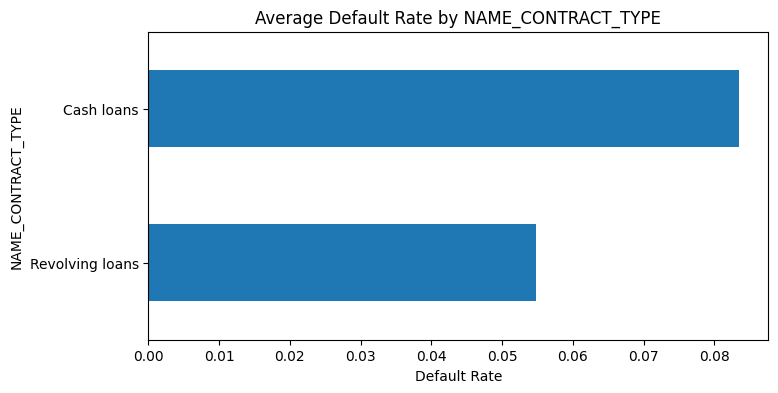

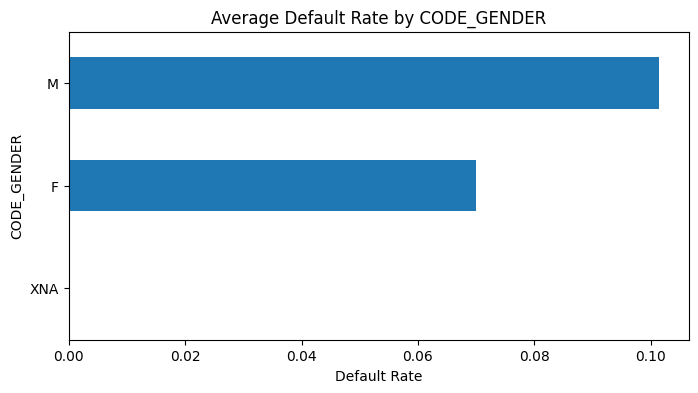

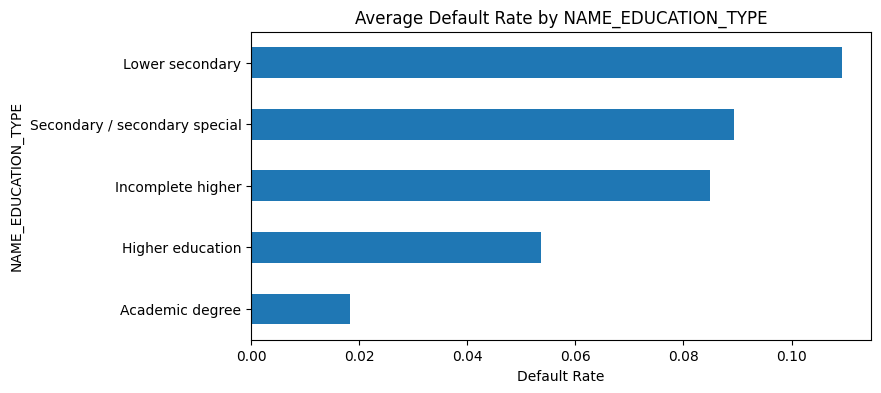

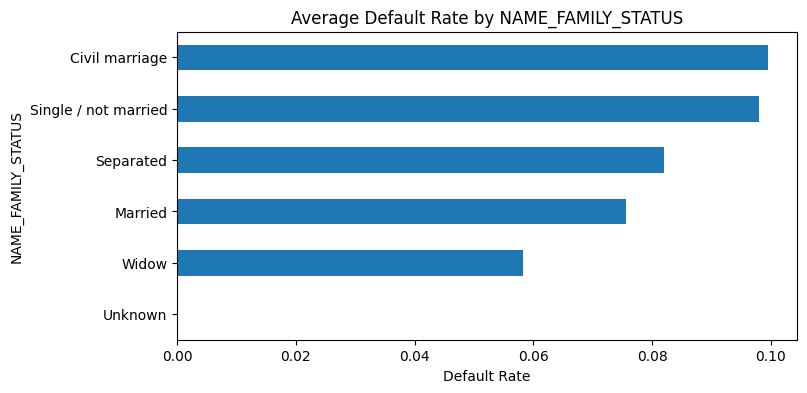

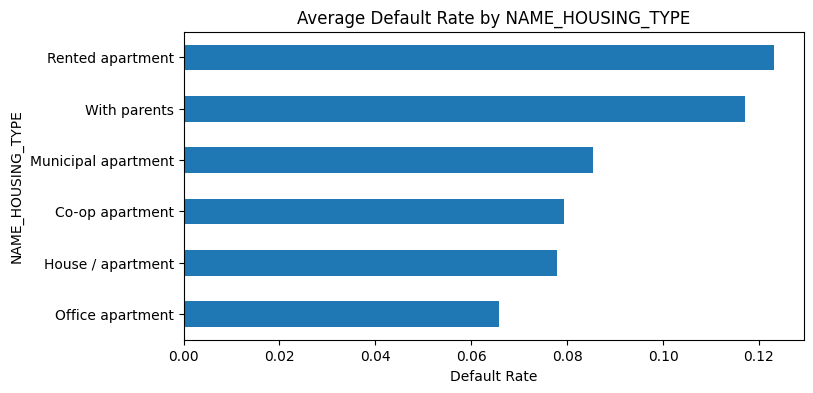

In [25]:
# Visualize Grouped Stats
for col in categorical:
    plt.figure(figsize=(8, 4))
    train_df.groupby(col)['TARGET'].mean().sort_values().plot(kind='barh')
    plt.title(f'Average Default Rate by {col}')
    plt.xlabel('Default Rate')
    plt.ylabel(col)
    plt.show()

##### Highest-Risk Categories:
The higher the number, the higher the risk for the below
- NAME_CONTRACT_TYPE: Cash loans (8.35%) have a higher default rate than Revolving loans (5.48%).
- CODE_GENDER: Male applicants (10.14%) have a significantly higher default rate than female applicants (7.00%).
- NAME_EDUCATION_TYPE: Applicants with a Lower secondary education (10.93%) have the highest default rate, followed by Secondary / secondary special (8.94%).
- NAME_FAMILY_STATUS: Applicants in a Civil marriage (9.94%) and those who are Single / not married (9.81%) have the highest default rates.
- NAME_HOUSING_TYPE: Applicants in a Rented apartment (12.31%) and those living with parents (11.70%) have the highest default rates.

##### Underserved or Misclassified Groups:
- Underserved: The analysis shows that applicants with Rented apartments or those living with parents have a very high default rate. A traditional, risk-a-verse lender might simply deny loans to all applicants in these categories. However, Home Credit's mission is to use alternative data to extend credit responsibly.

The Opportunity: The mean() shows the average risk. A better model could look at other factors within these high-risk groups (e.g., employment history, income stability) to find the sub-segment that is actually a good risk, thereby serving an otherwise excluded population.

- Misclassified: The most intriguing finding is the relationship between CODE_GENDER and default. The Male category has a significantly higher default rate. A basic, biased model might start discriminating against male applicants.

The Challenge: The question is why the male default rate is higher. Is it because men typically apply for different types of loans (Cash loans vs Revolving loans)? Is it due to differences in income or employment stability that are not captured by a simple gender-based analysis? The high default rate for males could be a symptom of an underlying issue, not the cause itself. The model should identify these underlying factors (e.g., loan type, income, employment) to avoid a simplistic and potentially unfair gender-based classification.

##### Potential Features to Prioritize in Modeling
The columns with the most significant variation in default rates are the most valuable for the model. They have the strongest predictive power. Based on the grouped statistics results, we can prioritize these features:

- NAME_HOUSING_TYPE: The difference in default rates between Rented apartment (12.31%) and Office apartment (6.57%) is massive (nearly 2x). This feature has very strong predictive power.
- NAME_EDUCATION_TYPE: The gap between Lower secondary (10.93%) and Academic degree (1.83%) is enormous. This is a top-tier predictor.
- CODE_GENDER: The M (10.14%) vs F (7.00%) default rate difference is substantial and worth including.
- NAME_FAMILY_STATUS: The default rates vary significantly across categories, with Civil marriage (9.94%) being a much higher risk than Widow (5.82%).

In [27]:
# Missing Value Summary
missing = train_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
                             ...  
EXT_SOURCE_2                   660
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
CNT_FAM_MEMBERS                  2
DAYS_LAST_PHONE_CHANGE           1
Length: 67, dtype: int64

- We can drop columns with >50% missing data.
- Impute remaining missing values using median (numerical) and mode (categorical).

### Step 3: Data Preparation 

In [30]:
## Handle Missing Values
# - High missingness (>50%): Consider dropping these columns unless they’re critical.
# - Moderate missingness: Impute with mean/median/mode or create a “missing” flag.
# - Low missingness: Impute directly.

# Drop columns with >50% missing values
missing_ratio = train_df.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.5].index
train_df.drop(columns=drop_cols, inplace=True)

# Impute numerical columns with median
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

# Impute categorical columns with mode
cat_cols = train_df.select_dtypes(include='object').columns
train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])

In [31]:
# Feature Engineering
# - Convert DAYS_BIRTH to age
# - Replace DAYS_EMPLOYED = 365243 with NaN
# - Create income-to-loan ratio

train_df['AGE'] = -train_df['DAYS_BIRTH'] / 365
train_df['DAYS_EMPLOYED'] = train_df['DAYS_EMPLOYED'].replace(365243, np.nan)
train_df['EMPLOYMENT_YEARS'] = -train_df['DAYS_EMPLOYED'] / 365
train_df['INCOME_CREDIT_RATIO'] = train_df['AMT_INCOME_TOTAL'] / train_df['AMT_CREDIT']
train_df['CHILDREN_RATIO'] = train_df['CNT_CHILDREN'] / train_df['CNT_FAM_MEMBERS']

# AMT_INCOME_TOTAL: Right-skewed due to high-income outliers. Needs log transformation
train_df['LOG_AMT_INCOME_TOTAL'] = np.log1p(train_df['AMT_INCOME_TOTAL'])

In [32]:
# Encode Categorical Variables
# - Use Label Encoding for binary categories
# - Use One-Hot Encoding for multi-class categories

# Label encode binary columns
le = LabelEncoder()
binary_cols = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
for col in binary_cols:
    train_df[col] = le.fit_transform(train_df[col])

# One-hot encode multi-class columns
train_df = pd.get_dummies(train_df, columns=['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'], drop_first=True)

In [33]:
# Find all object-type columns
remaining_cat_cols = train_df.select_dtypes(include='object').columns.tolist()
print("Remaining categorical columns:", remaining_cat_cols)

Remaining categorical columns: ['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE']


In [34]:
train_df = pd.get_dummies(train_df, columns=remaining_cat_cols, drop_first=True)

In [35]:
# Impute numerical columns with median
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

In [36]:
#train_df.head()

In [37]:
#print(train_df.isnull().sum().sum())  # Should be 0

In [38]:
## Split the data into train and test sets
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [39]:
# Address Class Imbalance - Use SMOTE (Synthetic Minority Oversampling Technique) to balance the target classes.
# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Step 4: Modeling: Baseline Classification

In [41]:
# Train logistic regression
model = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on validation set
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [42]:
# Calculate metrics
auc = roc_auc_score(y_val, y_proba)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

# Display results
print(f"AUC-ROC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
#print("Confusion Matrix:")
#print(cm)

AUC-ROC: 0.600
Precision: 0.107
Recall: 0.553
F1-score: 0.179


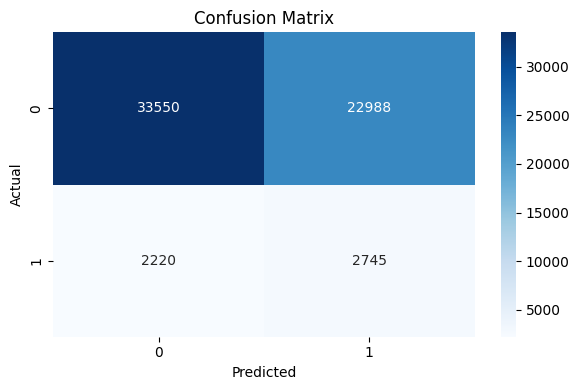

In [43]:
# Plot Confusion Matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

- AUC-ROC (0.600) is modest, and the model is learning something, but not much yet.
- Precision (0.107) is low, so it's flagging many people as risky who aren’t.
- Recall (0.553) is decent, which means the model is catching more than half of the actual defaulters.
- Convergence warning suggests the optimization didn’t fully settle—likely due to high dimensionality or feature scaling issues.

### Modeling: Logistic Regression

In [46]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train_resampled)
#X_val_scaled = scaler.transform(X_val)

#model = LogisticRegression(solver='saga', max_iter=2000, random_state=42)
#model.fit(X_train_scaled, y_train_resampled)

# Define the steps of the pipeline
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(solver='saga', max_iter=1000, random_state=42))
]

model_pipeline = Pipeline(steps=pipeline_steps)

model_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on validation set
y_pred = model_pipeline.predict(X_val)
y_proba = model_pipeline.predict_proba(X_val)[:, 1]

/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [47]:
# Calculate metrics
auc = roc_auc_score(y_val, y_proba)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

# Display results
print(f"AUC-ROC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
#print("Confusion Matrix:")
#print(cm)

AUC-ROC: 0.720
Precision: 0.397
Recall: 0.018
F1-score: 0.034


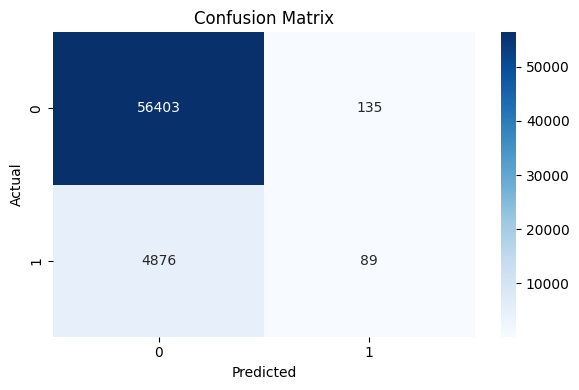

In [48]:
# Plot Confusion Matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

- AUC-ROC (0.720): Stronger ability to rank defaulters higher than non-defaulters—good sign overall.
- Precision (0.397): ~39.7% of predicted defaulters were actually defaulters—much improved from before
- Recall (0.018): Only ~1.8% of actual defaulters were identified—very low coverage.
- F1-score (0.034): Low balance between precision and recall
- Confusion Matrix shows model is extremely conservative—rarely flags defaulters, but when it does, it's more accurate

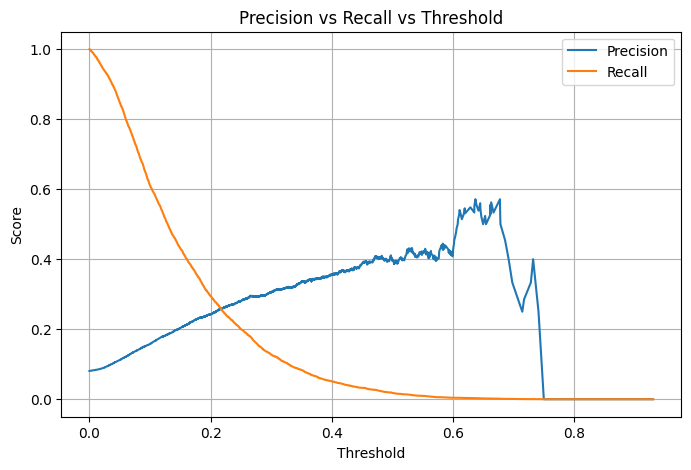

In [50]:
# Precision-Recall vs. Threshold Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [51]:
for t in [0.2, 0.3, 0.4]:
    y_pred_t = (y_proba >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_val, y_pred_t))



Threshold: 0.2
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     56538
           1       0.24      0.29      0.27      4965

    accuracy                           0.87     61503
   macro avg       0.59      0.61      0.60     61503
weighted avg       0.88      0.87      0.87     61503


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     56538
           1       0.31      0.13      0.18      4965

    accuracy                           0.91     61503
   macro avg       0.62      0.55      0.57     61503
weighted avg       0.88      0.91      0.89     61503


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56538
           1       0.36      0.05      0.09      4965

    accuracy                           0.92     61503
   macro avg       0.64      0.52      0.52     61503
weighted avg       0.88   

After evaluating the baseline logistic regression model,  performed threshold tuning to optimize the trade-off between precision and recall. The default threshold of 0.5 was too conservative, resulting in high precision but extremely low recall.

Tested thresholds of 0.2, 0.3, and 0.4:

| Threshold | Precision | Recall  | F1-score  | Accuracy |
|-----------|-----------|---------|-----------|----------|
| 0.2       | 0.24      | 0.29    | 0.27      | 0.87     |
| 0.3       | 0.31      | 0.13    | 0.18      | 0.91     |
| 0.4       | 0.36      | 0.05    | 0.09      | 0.92     |

Selected Threshold: 0.2
Rationale: This threshold offers the best balance between catching defaulters (recall) and minimizing false positives (precision), with a meaningful F1-score. It aligns with the business goal of identifying risky applicants without being overly conservative.

In [53]:
# Tuned with Threshold 0.25
threshold = 0.25
y_pred_tuned = (y_proba >= threshold).astype(int)

# Step 9: Evaluate
print(f"Classification Report (Threshold = {threshold}):")
print(classification_report(y_val, y_pred_tuned))

cm = confusion_matrix(y_val, y_pred_tuned)

Classification Report (Threshold = 0.25):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     56538
           1       0.28      0.20      0.23      4965

    accuracy                           0.89     61503
   macro avg       0.61      0.58      0.59     61503
weighted avg       0.88      0.89      0.89     61503



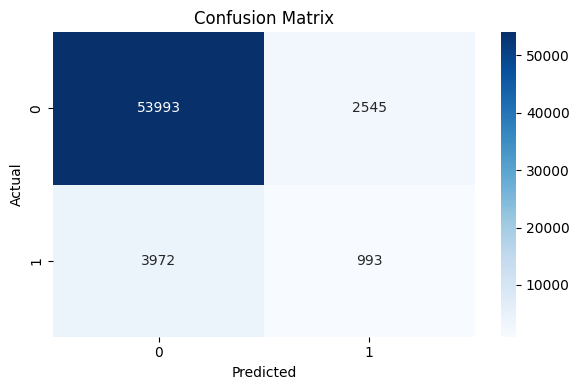

In [54]:
# Plot Confusion Matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Final Threshold Tuning

After evaluating multiple thresholds, I selected **0.25** as the optimal cutoff for classification. This threshold offers a meaningful balance between precision and recall, aligning with the business goal of identifying risky applicants without being overly conservative.

| Metric         | Value |
|----------------|-------|
| Precision (Class 1) | 0.28 |
| Recall (Class 1)    | 0.20 |
| F1-score (Class 1)  | 0.23 |
| Accuracy            | 0.89 |

**Confusion Matrix**:
- True Negatives: 53,993
- False Positives: 2,545
- False Negatives: 3,972
- True Positives: 993

This threshold tuning step significantly improved the model’s ability to detect defaulters, making it more actionable for real-world lending decisions.


### Modeling: RandomForest

In [57]:
# Random forest Pipeline
# Define pipeline steps
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
]

# Create pipeline
rf_pipeline = Pipeline(steps=pipeline_steps)

# Fit on resampled training data
rf_pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on validation set
y_pred_rf = rf_pipeline.predict(X_val)
y_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]

In [58]:
# Calculate metrics
auc = roc_auc_score(y_val, y_proba_rf)
cm = confusion_matrix(y_val, y_pred_rf)

print("Classification Report:")
print(classification_report(y_val, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.20      0.01      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.56      0.50      0.48     61503
weighted avg       0.86      0.92      0.88     61503



In [59]:
print(cm)

[[56410   128]
 [ 4933    32]]


Recall is lower: it misses nearly all defaulters.

Precision is lower: it has more false positives per correct prediction.

High accuracy: But misleading due to class imbalance.

AUC-ROC is decent: Suggests potential if threshold is tuned.

In [61]:
# Predict probabilities for class 1
y_proba_rf = rf_pipeline.predict_proba(X_val)[:, 1]

# Define thresholds to test
thresholds = [0.2, 0.25, 0.3, 0.4]

# Loop through thresholds and evaluate
for t in thresholds:
    y_pred_tuned = (y_proba_rf >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(f"Precision: {precision_score(y_val, y_pred_tuned):.3f}")
    print(f"Recall: {recall_score(y_val, y_pred_tuned):.3f}")
    print(f"F1-score: {f1_score(y_val, y_pred_tuned):.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred_tuned))
    print("Classification Report:")
    print(classification_report(y_val, y_pred_tuned))


Threshold: 0.2
Precision: 0.171
Recall: 0.436
F1-score: 0.246
Confusion Matrix:
[[46083 10455]
 [ 2802  2163]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     56538
           1       0.17      0.44      0.25      4965

    accuracy                           0.78     61503
   macro avg       0.56      0.63      0.56     61503
weighted avg       0.88      0.78      0.82     61503


Threshold: 0.25
Precision: 0.200
Recall: 0.272
F1-score: 0.230
Confusion Matrix:
[[51140  5398]
 [ 3617  1348]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     56538
           1       0.20      0.27      0.23      4965

    accuracy                           0.85     61503
   macro avg       0.57      0.59      0.57     61503
weighted avg       0.87      0.85      0.86     61503


Threshold: 0.3
Precision: 0.225
Recall: 0.152
F1-score: 0.182
Confusion Ma

### Model Comparison: Logistic Regression vs Random Forest

| Metric              | Logistic Regression<br>(Threshold = 0.25) | Random Forest<br>(Threshold = 0.25) |
|---------------------|-------------------------------------------|-------------------------------------|
| Precision (Class 1) | 0.28                                      | 0.20                                |
| Recall (Class 1)    | 0.20                                      | 0.27                                |
| F1-score (Class 1)  | 0.23                                      | 0.23                                |
| Accuracy            | 0.89                                      | 0.85                                |
| AUC-ROC             | 0.720                                     | 0.694                               |

Logistic Regression
- Higher precision: Fewer false positives.
- Better AUC-ROC: Stronger ranking ability.
- Higher accuracy: More correct predictions overall.
- More stable and interpretable: Great for explaining decisions.

Random Forest
- Higher recall: Catches more defaulters—27% vs. 20%.
- Similar F1-score: Slightly better balance between precision and recall.
- Lower accuracy: Acceptable trade-off for better recall.
- Nonlinear modeling: Captures complex patterns that logistic regression may miss.

- If catching more defaulters is critical, Random Forest at threshold 0.25 is the best bet.
- If avoiding false positives and maintaining interpretability is more important, Logistic Regression is better.

### Modeling: Decision Tree

In [64]:
#Define pipeline
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
]

xgb_pipeline = Pipeline(steps=pipeline_steps)

# Step 5: Fit model
xgb_pipeline.fit(X_train_resampled, y_train_resampled)

# Step 6: Predict with tuned threshold
y_proba_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.25).astype(int)

# Step 7: Evaluate
print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

print(f"AUC-ROC: {roc_auc_score(y_val, y_proba_xgb):.3f}")

/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:09:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     56538
           1       0.24      0.23      0.24      4965

    accuracy                           0.88     61503
   macro avg       0.59      0.58      0.59     61503
weighted avg       0.88      0.88      0.88     61503

Confusion Matrix:
[[52850  3688]
 [ 3800  1165]]
AUC-ROC: 0.718


### Model Comparison: Logistic Regression vs Random Forest vs XGBoost (Threshold = 0.25)

| Metric              | Logistic Regression | Random Forest | XGBoost |
|---------------------|---------------------|---------------|---------|
| Precision (Class 1) | 0.28                | 0.20          | 0.24    |
| Recall (Class 1)    | 0.20                | 0.27          | 0.23    |
| F1-score (Class 1)  | 0.23                | 0.23          | 0.24    |
| Accuracy            | 0.89                | 0.85          | 0.88    |
| AUC-ROC             | 0.720               | 0.694         | 0.718   |

XGBoost
- Best F1-score: Slight edge in balancing precision and recall.
- Strong AUC-ROC: Nearly matches Logistic Regression.
- Good accuracy: Slightly below Logistic Regression, but better than Random Forest.
- Robust model: Captures nonlinear patterns and interactions.

Logistic Regression
- Highest precision: Fewer false positives.
- Best AUC-ROC: Strongest ranking ability.
- Most interpretable: Ideal for explainability and regulatory settings.

Random Forest
- Highest recall: Catches more defaulters.
- Lower precision and accuracy: More aggressive, but less precise.


- If the business wants balanced performance with good recall and precision: XGBoost is the best bet.
- If the business prioritizes interpretability and precision: Logistic Regression is better option.
- If the goal is to maximize recall and catch as many defaulters as possible: Random Forest still leads.

In [66]:
# Hyperparameter Tuning

# Define base model
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]  # Adjust if not using SMOTE
}

# Run grid search
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/openAI/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:09:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 1.0}


In [67]:
y_proba_xgb = grid_search.predict_proba(X_val)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.25).astype(int)

print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

print(f"AUC-ROC: {roc_auc_score(y_val, y_proba_xgb):.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     56538
           1       0.31      0.21      0.25      4965

    accuracy                           0.90     61503
   macro avg       0.62      0.58      0.60     61503
weighted avg       0.88      0.90      0.89     61503

Confusion Matrix:
[[54276  2262]
 [ 3931  1034]]
AUC-ROC: 0.746


### Model Comparison: Logistic Regression vs Random Forest vs XGBoost-Tuned (Threshold = 0.25)

| Metric              | Logistic Regression | Random Forest | XGBoost | XGBoost (Tuned) |
|---------------------|---------------------|---------------|---------|-----------------|
| Precision (Class 1) | 0.28                | 0.20          | 0.24    | 0.31            |
| Recall (Class 1)    | 0.20                | 0.27          | 0.23    | 0.21            |
| F1-score (Class 1)  | 0.23                | 0.23          | 0.24    | 0.25            |
| Accuracy            | 0.89                | 0.85          | 0.88    | 0.90            |
| AUC-ROC             | 0.720               | 0.694         | 0.718   | 0.746           |

XGBoost (Tuned)
- Best precision: Fewer false positives.
- Best F1-score: Most balanced between precision and recall.
- Highest AUC-ROC: Strongest ability to rank defaulters correctly.
- High accuracy: Without sacrificing minority class detection.

In [69]:
y_proba_xgb = grid_search.predict_proba(X_val)[:, 1]
y_pred_xgb = (y_proba_xgb < 0.25).astype(int)

print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

print(f"AUC-ROC: {roc_auc_score(y_val, y_proba_xgb):.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.04      0.08     56538
           1       0.07      0.79      0.12      4965

    accuracy                           0.10     61503
   macro avg       0.38      0.42      0.10     61503
weighted avg       0.64      0.10      0.08     61503

Confusion Matrix:
[[ 2262 54276]
 [ 1034  3931]]
AUC-ROC: 0.746


In [70]:
def find_optimal_threshold(y_true, y_proba, metric='f1'):
    thresholds = np.arange(0.1, 0.5, 0.01)
    scores = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precision, recall = precision_score(y_true, y_pred), recall_score(y_true, y_pred)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
        scores.append((t, precision, recall, f1))
    best = max(scores, key=lambda x: x[3])  # Maximize F1
    return best

best_threshold = find_optimal_threshold(y_val, y_proba_xgb)
print(f"Best threshold: {best_threshold[0]:.2f} with F1-score: {best_threshold[3]:.3f}")

Best threshold: 0.18 with F1-score: 0.294


In [71]:
y_pred_xgb = (y_proba_xgb >= 0.18).astype(int)

print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

print(f"AUC-ROC: {roc_auc_score(y_val, y_proba_xgb):.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     56538
           1       0.25      0.35      0.29      4965

    accuracy                           0.86     61503
   macro avg       0.60      0.63      0.61     61503
weighted avg       0.89      0.86      0.87     61503

Confusion Matrix:
[[51431  5107]
 [ 3228  1737]]
AUC-ROC: 0.746


### Model Comparison

| Metric              | Logistic Regression <br> (Threshold = 0.25) | Random Forest <br> (Threshold = 0.25) | XGBoost <br> (Threshold = 0.25)    | XGBoost (Tuned) <br> (Threshold = 0.25) | XGBoost (Tuned) <br> (Threshold = 0.18) |
|---------------------|---------------------|---------------|------------|-----------------|-----------------|
| Precision (Class 1) | 0.28                | 0.20          | 0.24       | 0.31            | 0.25            |
| Recall (Class 1)    | 0.20                | 0.27          | 0.23       | 0.21            | 0.35            |
| F1-score (Class 1)  | 0.23                | 0.23          | 0.24       | 0.25            | 0.29            |
| Accuracy            | 0.89                | 0.85          | 0.88       | 0.90            | 0.86            |
| AUC-ROC             | 0.720               | 0.694         | 0.718      | 0.746           | 0.746           |

XGBoost (Tuned with Threshold = 0.18)
- Best F1-score across all models and thresholds.
- Strong recall without collapsing precision.
- High accuracy—model is still reliable overall.
- Robust AUC-ROC—your model ranks defaulters well even if threshold shifts.

### Step 5: Feature Analysis: XGBoost Model for Loan Default Prediction

In [108]:
# Plot the Tree
#plt.figure(figsize=(30, 400)) 
#xgb.plot_tree(best_xgb, tree_idx=0)
#plt.show()

<Figure size 1000x600 with 0 Axes>

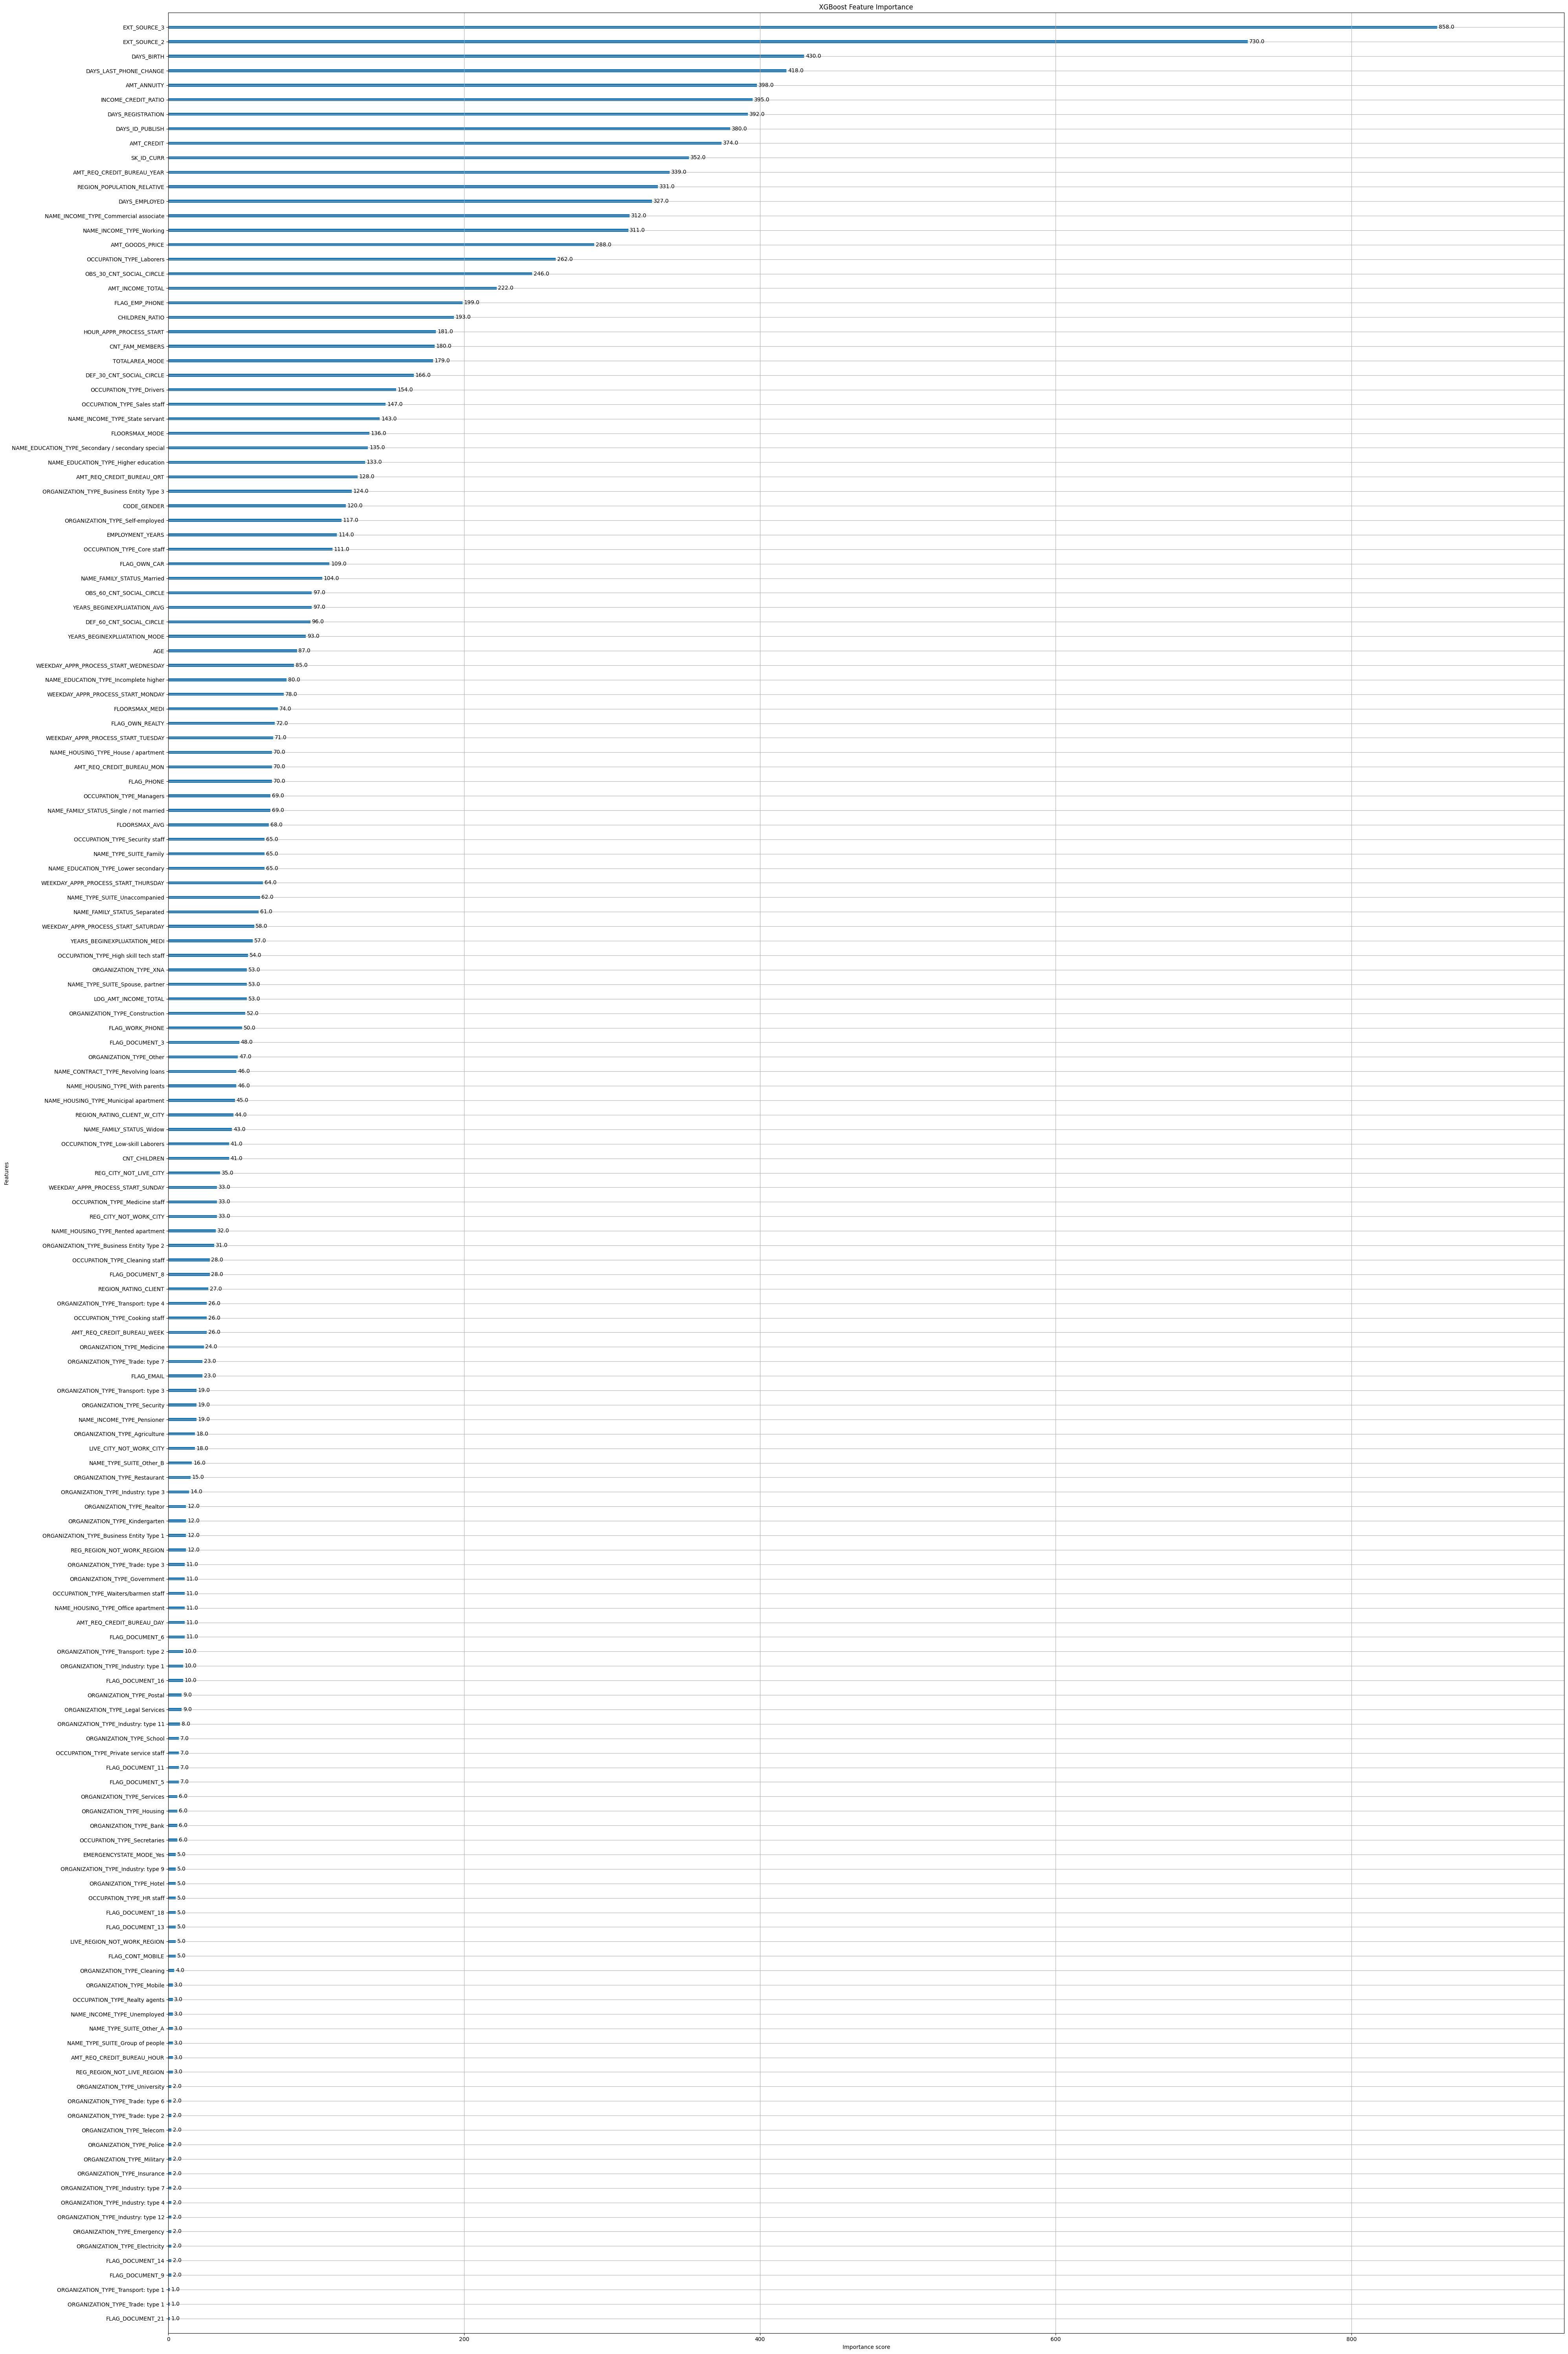

In [110]:
# Feature Importance
xgb_model = grid_search.best_estimator_

booster = xgb_model.get_booster()

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(booster, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

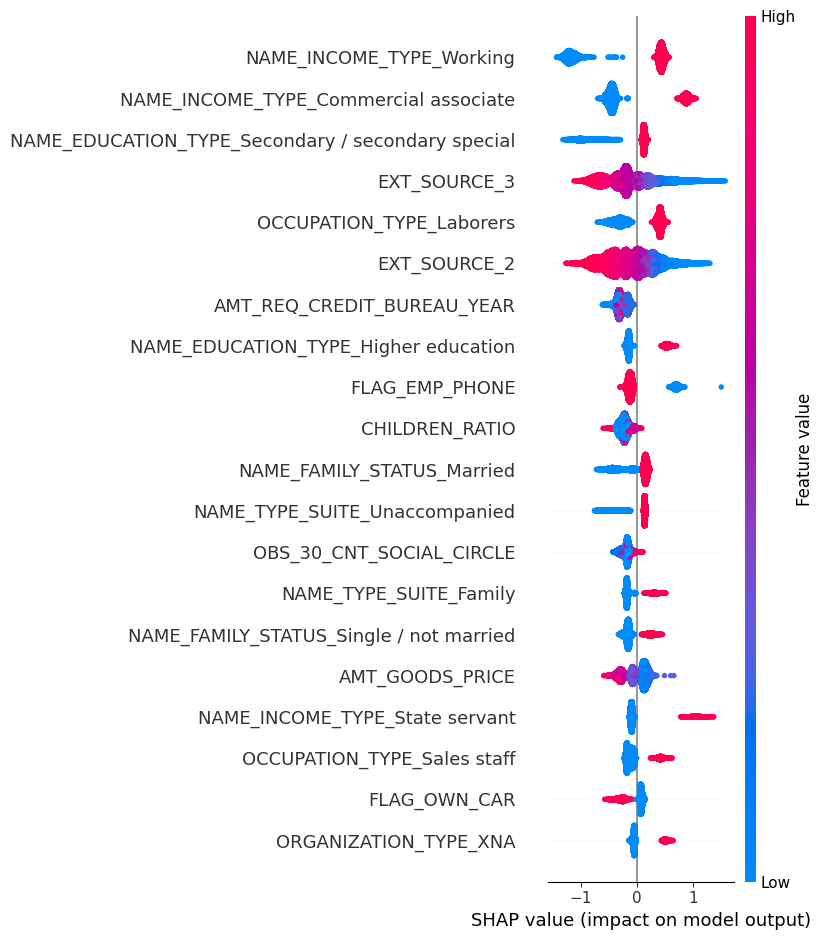

In [111]:

# Extract the booster from the best estimator
booster = xgb_model.get_booster()

explainer = shap.TreeExplainer(booster)

#X_val = X_val.select_dtypes(include=[np.number])

# Compute SHAP values
shap_values = explainer.shap_values(X_val)

# Plot summary
shap.summary_plot(shap_values, X_val)

Used SHAP summary plot to rank features by their average impact on model predictions.

Top features included:

- EXT_SOURCE_3
- OCCUPATION_TYPE_Laborers
- NAME_INCOME_TYPE_Working
- AMT_REQ_CREDIT_BUREAU_YEAR
- EMP_Ratio

One-hot encoded categorical features (e.g., NAME_EDUCATION_TYPE_Secondary / secondary sp.) appeared as separate entries.

Insight: These features are the primary drivers of the model’s decision logic.

SHAP values quantify how each feature pushes a prediction higher or lower for each borrower.

Positive SHAP value → increases predicted risk

Negative SHAP value → decreases predicted risk

Example:

EXT_SOURCE_3 had mostly negative SHAP values for high scores, indicating it reduces default risk.

OCCUPATION_TYPE_Laborers showed positive SHAP values, suggesting increased risk.

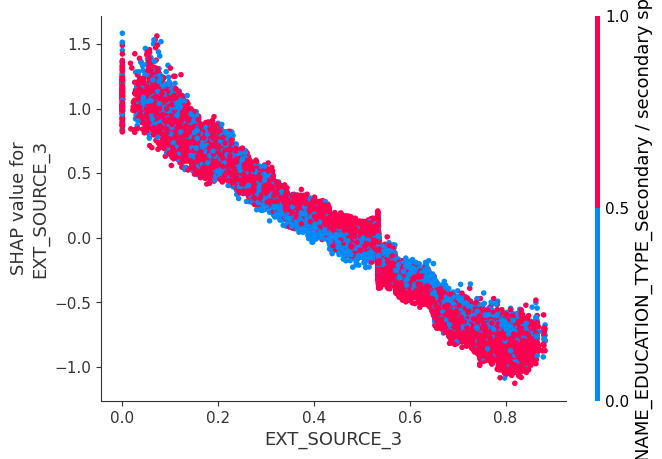

In [114]:
# Dependence Plot: EXT_SOURCE_3

explainer = shap.TreeExplainer(xgb_model.get_booster())
shap_values = explainer.shap_values(X_val)

# Dependence plot for EXT_SOURCE_3
shap.dependence_plot("EXT_SOURCE_3", shap_values, X_val)

- X-axis: Actual values of EXT_SOURCE_3
- Y-axis: SHAP values for EXT_SOURCE_3
- Color gradient: NAME_EDUCATION_TYPE_Secondary / secondary sp.

Findings:
- Higher EXT_SOURCE_3 values → lower SHAP values → reduced default risk.
- Interaction with education level: borrowers with secondary education showed stronger risk reduction from high EXT_SOURCE_3 scores.

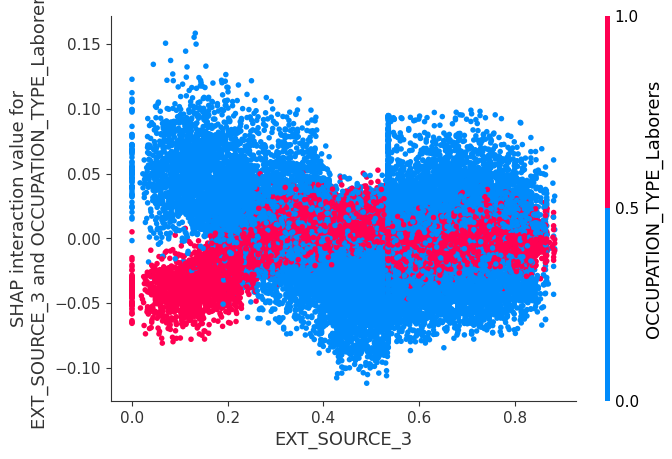

In [116]:
# EXT_SOURCE_3 × OCCUPATION_TYPE_Laborers

explainer = shap.TreeExplainer(xgb_model.get_booster())
interaction_values = explainer.shap_interaction_values(X_val)

shap.dependence_plot(
    ("EXT_SOURCE_3", "OCCUPATION_TYPE_Laborers"), 
    interaction_values, 
    X_val
)

#### EXT_SOURCE_3 × OCCUPATION_TYPE_Laborers
- Laborers with low EXT_SOURCE_3 scores receive less risk reduction than non-laborers.
- The model penalizes laborers more when creditworthiness is low.
- Interpretation: Occupation dampens the protective effect of EXT_SOURCE_3.

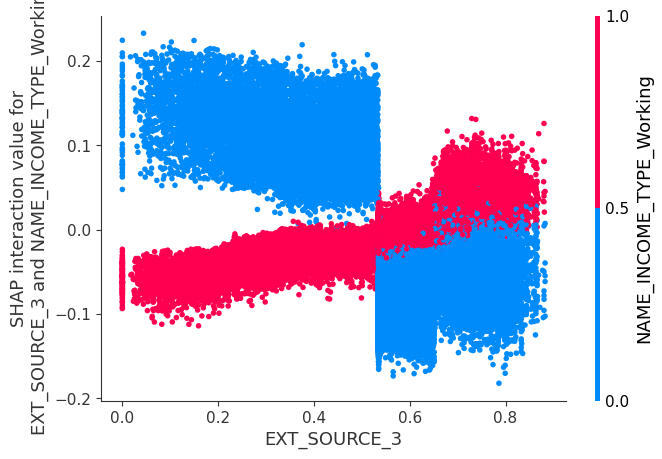

In [118]:
# EXT_SOURCE_3 × NAME_INCOME_TYPE_Working
explainer = shap.TreeExplainer(xgb_model.get_booster())
interaction_values = explainer.shap_interaction_values(X_val)

# Example: EXT_SOURCE_3 × NAME_INCOME_TYPE_Working
shap.dependence_plot(("EXT_SOURCE_3", "NAME_INCOME_TYPE_Working"), interaction_values, X_val)

#### EXT_SOURCE_3 × NAME_INCOME_TYPE_Working
- Working individuals benefit more from high EXT_SOURCE_3 scores.
- Their SHAP interaction values are more negative, indicating greater risk reduction.
- Interpretation: Employment amplifies the protective effect of EXT_SOURCE_3.